# Generatywne sieci przeciwstawne

- oryginalna praca o GAN: https://arxiv.org/abs/1406.2661
- DCGAN: https://arxiv.org/abs/1511.06434
- ćwiczenie oparte na przykładzie z dokumentacji PyTorch: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor, Normalize, Compose     # transformacje obrazu
from PIL import Image                       # wczytanie pliku graficznego

from glob import glob                       # wczytanie listy plików
from tqdm import trange                    # pasek postępu
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
!sudo apt install imagemagick

In [ ]:
!cd frames_dwojka; for i in *.png; do convert -resize 128x128 -gravity center -extent 128x128 -background black $i ../frames_male/$i; echo $i; done

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
!unzip -u /content/drive/MyDrive/lssn/projekt_bbgan/klatki_13k_128x128.zip

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
  inflating: klatki/bbgan_4235.png   
  inflating: klatki/bbgan_3292.png   
  inflating: klatki/bbgan_13206.png  
  inflating: klatki/bbgan_13075.png  
  inflating: klatki/bbgan_4261.png   
  inflating: klatki/bbgan_7513.png   
  inflating: klatki/bbgan_7314.png   
  inflating: klatki/bbgan_1541.png   
  inflating: klatki/bbgan_2657.png   
  inflating: klatki/bbgan_9077.png   
  inflating: klatki/bbgan_5634.png   
  inflating: klatki/bbgan_2922.png   
  inflating: klatki/bbgan_4691.png   
  inflating: klatki/bbgan_8308.png   
  inflating: klatki/bbgan_0430.png   
  inflating: klatki/bbgan_7903.png   
  inflating: klatki/bbgan_0494.png   
  inflating: klatki/bbgan_2047.png   
  inflating: klatki/bbgan_10305.png  
  inflating: klatki/bbgan_6571.png   
  inflating: klatki/bbgan_4514.png   
  inflating: klatki/bbgan_3700.png   
  inflating: klatki/bbgan_0827.png   
  inflating: klatki/bbgan_10059.png  
  inflating: klatki/bbg

In [5]:
class FacesDataset(Dataset):
    def __init__(self, root):
        self.images = sorted(glob(f'{root}/bbgan_[0-3]???.png'))
        self.transform = Compose([
            ToTensor(),
            Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx])
        return self.transform(image)

ds = FacesDataset('klatki/')
### dl = DataLoader(ds, batch_size=16, shuffle=True)
dl = DataLoader(ds, batch_size=16, shuffle=True)
print("Razem %d obrazkow" % len(ds.images))

Razem 3999 obrazkow


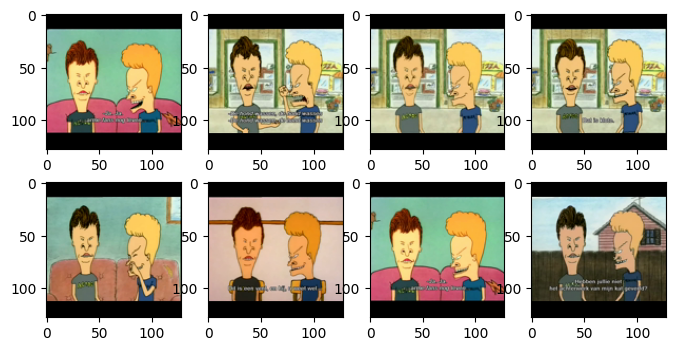

In [6]:
images = next(iter(dl))
cols, rows = 4, 2
fig, axs = plt.subplots(rows, cols, figsize=(2*cols, 2*rows))
for image, ax in zip(images, axs.flat):
    ax.imshow((image.permute(1, 2, 0)+1)/2)
    #ax.axis('off')

In [7]:
# bloki wg zaleceń z pracy o DCGAN (ramka na stronie 3)

def Conv(in_channels, out_channels, kernel_size, stride, padding):
    # blok do dyskryminatora, obniża rozdzielczość
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2, inplace=True),
    )

def ConvT(in_channels, out_channels, kernel_size, stride, padding):
    # blok do generatora, zwiększa rozdzielczość
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )

In [8]:
# generator wg Fig.1 z pracy o DCGAN
# brak warstw liniowych, wg zaleceń

def Generator(latent_dim, features=8):  # input: latent_dim, 1, 1
    return nn.Sequential(
        ConvT(latent_dim, 16*features, 4, 1, 0),   # 16f, 4, 4, latent_dim = mapa 100 cech "1x1" px
        ConvT(16*features, 8*features, 4, 2, 1),    # 8f, 8, 8
        ConvT(8*features, 4*features, 4, 2, 1),     # 4f, 16, 16
        ConvT(4*features, 2*features, 4, 2, 1),     # 2f, 32, 32
        ConvT(2*features, features, 4, 2, 1),       # f, 64, 64
        nn.ConvTranspose2d(features, 3, 4, 2, 1),   # 3, 128, 128
        nn.Tanh()
    )

# klasyfikator binarny (1 neuron na wyjściu z f. sigmoidalną)
# brak warstw liniowych, wg zaleceń

def Discriminator(features=8):
    return nn.Sequential(
        Conv(3, features, 4, 2, 1),                # f, 64, 64
        Conv(features, 2*features, 4, 2, 1),       # 2f, 32, 32
        Conv(2*features, 4*features, 4, 2, 1),     # 4f, 16, 16
        Conv(4*features, 8*features, 4, 2, 1),     # 8f, 8, 8
        Conv(8*features, 16*features, 4, 2, 1),    # 16f, 4, 4

        nn.Conv2d(16*features, 1, 4),              # Splot 4x4 -> robi 1 piksel
        nn.Sigmoid()
    )

torch.Size([1, 3, 128, 128])


tensor([0.5875, 0.4905, 0.5070, 0.5519, 0.4546, 0.4395, 0.5251, 0.5698, 0.5851,
        0.4762, 0.5448, 0.6303, 0.4925, 0.5274, 0.5197, 0.5518],
       device='cuda:0', grad_fn=<ViewBackward0>)

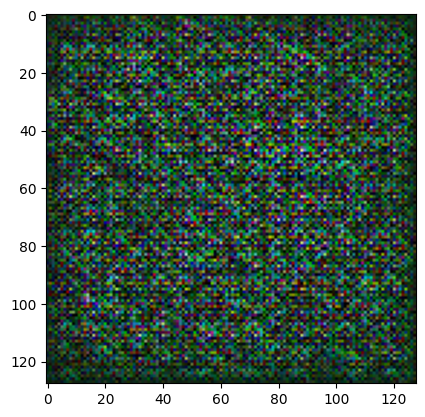

In [9]:
gen = Generator(100).to(device)
# Generator na wejściu dostaje wektor, który jest szumem
n = torch.randn(1, 100, 1, 1).to(device)
out = gen(n)
print(out.shape)
plt.imshow(out.detach().cpu().movedim(1, 3)[0])

d = Discriminator().to(device)
#y = d(out)
y = d(dl.__iter__().__next__().to(device))
y.view(-1)

In [ ]:
print(next(iter(dl)).shape)

torch.Size([16, 3, 128, 128])


In [10]:
# inicjalizacja wag wg zaleceń z pracy o DCGAN (sekcja 4, strona 3.)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Pętla parametrów

In [144]:
latent_dim = 40
features = 40
learning_rate = 2e-4    # autorzy używają 2e-4, ale dla mniejszych obrazów
total_epochs = 0




In [145]:
# Reset sieci
gen = Generator(latent_dim, features).to(device)
dis = Discriminator(features).to(device)
gen.apply(weights_init)
dis.apply(weights_init);

loss_fn = nn.BCELoss()  # Binary Cross Entropy jako funkcja straty

In [146]:
# zalecane parametry algorytmu Adam z pracy o DCGAN (sekcja 4)
gen_opt = torch.optim.Adam(gen.parameters(), lr = learning_rate, betas=(0.5, 0.999))
dis_opt = torch.optim.Adam(dis.parameters(), lr = learning_rate, betas=(0.5, 0.999))


In [147]:
history_g=[]
history_d=[]

In [148]:
# ustalony szum, by testować postępy w uczeniu generatora

fixed_noise=torch.randn(24, latent_dim, 1, 1).to(device)

def test_gen(noise):
    gen.eval()
    with torch.no_grad():
        fake = gen(noise).detach().cpu()
    return fake

def test_plot(epoch = None, random = False):
    if random:
      fake=test_gen(torch.randn(24, latent_dim, 1, 1).to(device)).movedim(1, 3)
    else:
      fake=test_gen(fixed_noise).movedim(1, 3)
    fig, axs = plt.subplots(1,3, figsize=(10,3))
    for ax, im in zip(axs.flatten(), fake):
        ax.imshow((im+1)/2)
        ax.axis('off')
    plt.title("nFeat=%d, latDim=%d, LR=%f, ep=%s" % (features, latent_dim, learning_rate, epoch))
    fig.tight_layout()

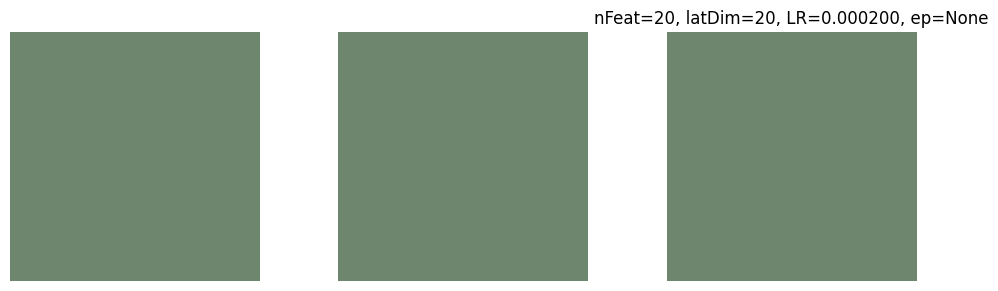

In [140]:
test_plot()

In [141]:
# opierając się na oryginalnej pracy o GAN (I. Goodfellow), napisz pętlę uczenia

def train_loop():
    size = len(dl.dataset)
    total_gen_loss = 0
    total_dis_loss = 0
    for x in dl:
        # uczenie dyskryminatora
        dis.zero_grad()

        # rzeczywiste obrazy
        real = x.to(device)
        real_output = dis(real).view(-1)
        dis_real_loss = loss_fn(real_output, torch.ones_like(real_output))

        # syntetyczne obrazy
        noise = torch.randn(x.shape[0], latent_dim, 1, 1).to(device)
        fake = gen(noise)
        fake_output = dis(fake.detach()).view(-1)
        dis_fake_loss = loss_fn(fake_output, torch.zeros_like(fake_output))

        dis_real_loss.backward()
        dis_fake_loss.backward()

        dis_opt.step()

        # uczenie generatora
        gen.zero_grad()
        out = dis(fake).view(-1)
        gen_loss = loss_fn(out, torch.ones_like(out))
        gen_loss.backward()
        gen_opt.step()
        dis_loss = dis_real_loss+dis_fake_loss
        total_dis_loss += dis_loss.item()
        total_gen_loss += gen_loss.item()

    return total_gen_loss/size, total_dis_loss/size


LR=0.000200, nF=20, lDi=20


 17%|█▋        | 1/6 [00:09<00:46,  9.23s/it, DisL=0.0151, GenL=0.547]

Loss =  0.5468315190450941


 33%|███▎      | 2/6 [00:18<00:37,  9.50s/it, DisL=0.0195, GenL=0.539]

Loss =  0.5391035330358164


 50%|█████     | 3/6 [00:28<00:28,  9.57s/it, DisL=0.0156, GenL=0.292]

Loss =  0.2918055860023404


 67%|██████▋   | 4/6 [00:37<00:18,  9.31s/it, DisL=0.0176, GenL=0.279]

Loss =  0.2786991003934302


 83%|████████▎ | 5/6 [00:47<00:09,  9.44s/it, DisL=0.0122, GenL=0.301]

Loss =  0.3013552886884074


100%|██████████| 6/6 [00:57<00:00,  9.63s/it, DisL=0.0162, GenL=0.309]


Loss =  0.3087828332527067


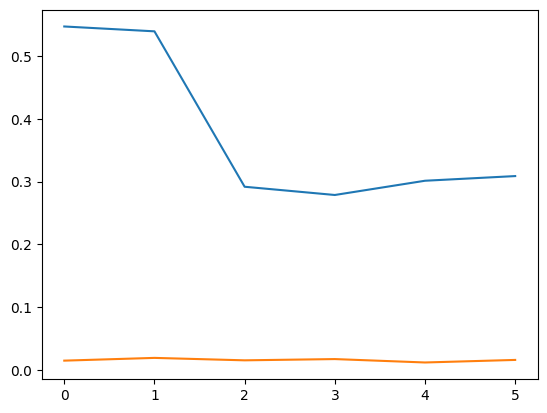

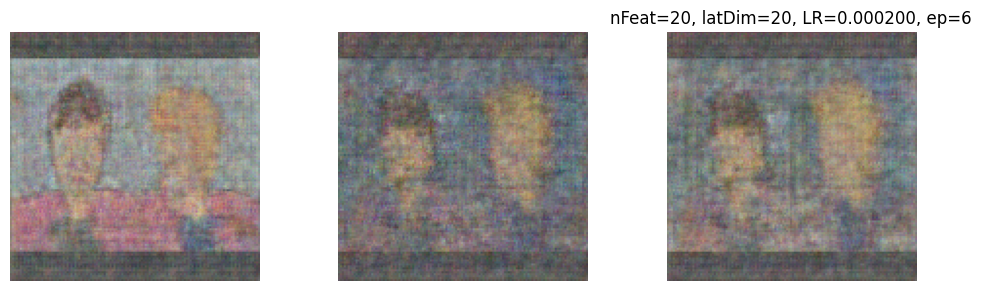

In [142]:
print("LR=%f, nF=%d, lDi=%d" % (learning_rate, features, latent_dim))
epochs = 6
dis.train()
gen.train()
loop = trange(epochs)
for epoch in loop:
    g_loss, d_loss = train_loop()
    history_d.append(d_loss)
    history_g.append(g_loss)
    loop.set_postfix(DisL=d_loss, GenL=g_loss)
    print("Loss = ", g_loss)
    total_epochs += 1
    #test_plot(epoch)
    #gen.train()
plt.plot(history_g)
plt.plot(history_d)
test_plot(total_epochs)

# Test wyjsc

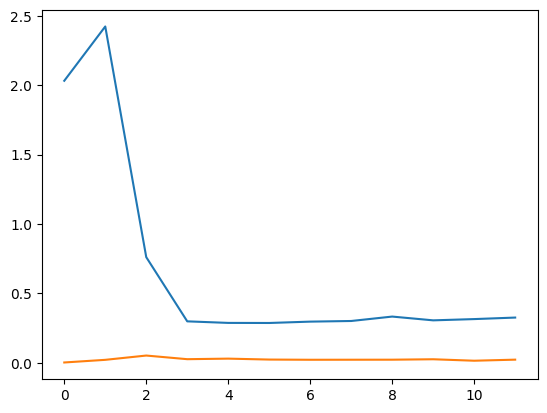

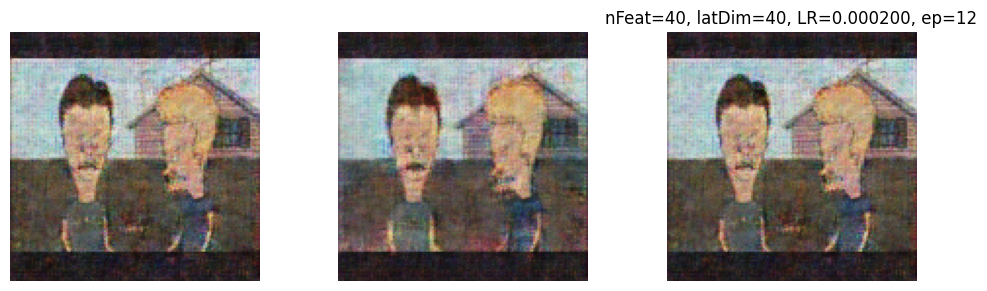

In [130]:
plt.plot(history_g)
plt.plot(history_d)
test_plot(total_epochs, False)


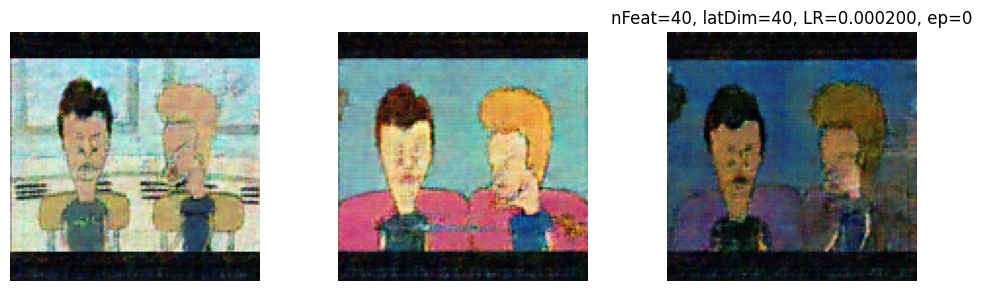

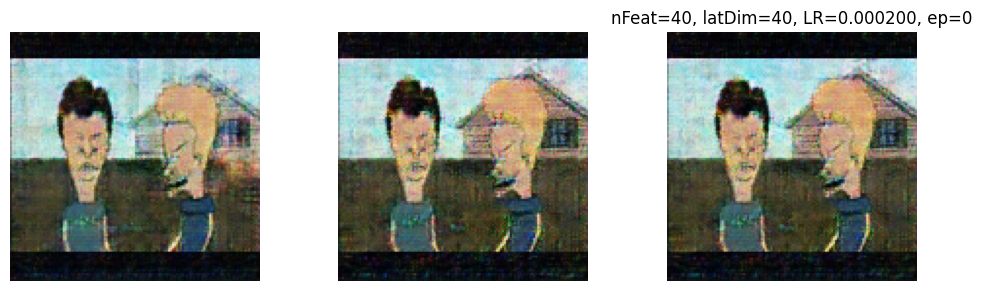

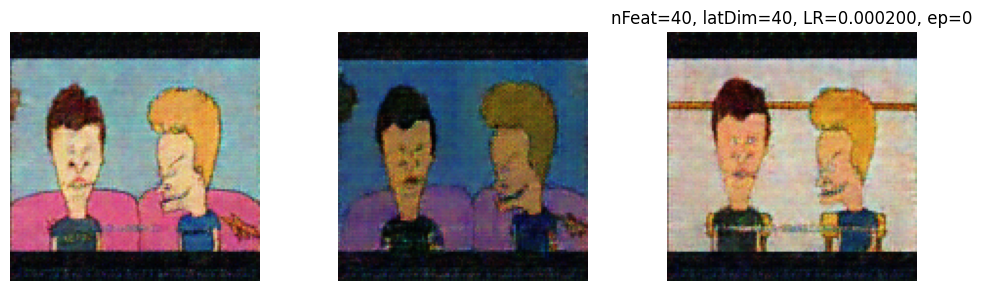

In [150]:
test_plot(total_epochs, True)
test_plot(total_epochs, True)
test_plot(total_epochs, True)

In [62]:
torch.save({
            'gen_state_dict': gen.state_dict(),
            'gen_opt_state_dict': gen_opt.state_dict(),
            'dis_state_dict': dis.state_dict(),
            'dis_opt_state_dict': dis_opt.state_dict()
            }, f"/content/drive/MyDrive/lssn/projekt_bbgan/checkpoint_z{latent_dim}_f{features}_ep{total_epochs}_lr{learning_rate}-final.pkl")

In [ ]:
learning_rate=1e-4

In [ ]:
learning_rate

0.0001

In [ ]:
features

64

In [149]:
#checkpoint = torch.load(f"checkpoint_z{latent_dim}_f{features}.pkl", map_location=device)
checkpoint = torch.load(f"/content/drive/MyDrive/lssn/projekt_bbgan/checkpoint_z40_f40_ep30_lr0.0004-dobre3.pkl"
                    , map_location=device)
gen.load_state_dict(checkpoint['gen_state_dict'])
gen_opt.load_state_dict(checkpoint['gen_opt_state_dict'])
dis.load_state_dict(checkpoint['dis_state_dict'])
dis_opt.load_state_dict(checkpoint['dis_opt_state_dict'])

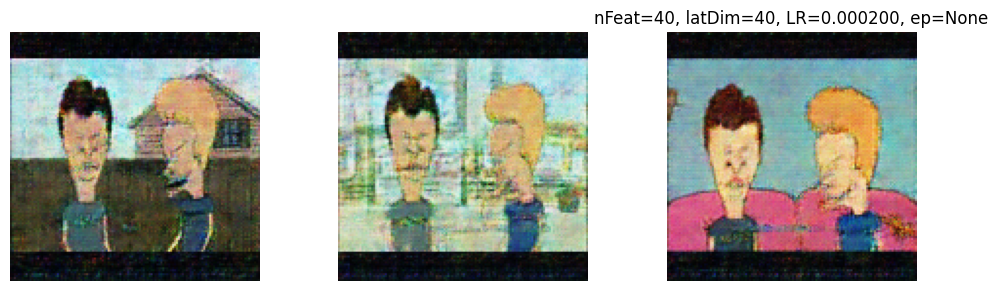

In [ ]:
test_plot(random=True)

In [172]:
aa=torch.zeros(48, latent_dim, 1, 1).to(device)
aa[0] = torch.randn(latent_dim, 1, 1).to(device)
for i in range(1, 48):
  aa[i] = aa[i-1] + 0.3 * torch.randn(latent_dim, 1, 1).to(device)


fake=test_gen(aa).movedim(1, 3)

fig, axs = plt.subplots(4,6, figsize=(15,10))
for ax, im in zip(axs.flatten(), fake):
    ax.imshow((im+1)/2)
    ax.axis('off')
fig.tight_layout()

In [160]:
onehot

tensor([[[[1.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]]]], device='cuda:0')